# Part 7 - Exploring the Essemble of Random Forests

Exploring the Trends of VPD

## General Set up

In [1]:
import numpy as np
import pandas as pd
import os 
import sys
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import root_mean_squared_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler


from scipy.stats import gaussian_kde
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import TheilSenRegressor

import seaborn as sns
sns.set()
sns.set_style("whitegrid") 
sns.set_context("paper")

from joblib import load
from pygam import LinearGAM
from matplotlib.patches import Rectangle
import string
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import sigfig

In [2]:
results_dir = 'E:/Krish_New/Dynamic_Vegetation_Project_Storage/Random_Forest_Results_On_Super_Group_Results'
results_dir = 'C:/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/au_dyanamic_vegetation_project/RESULTS/Random_Forest_Results_On_Super_Group_Results_new'
directory = 'C:/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/au_dyanamic_vegetation_project/DATASETS/MODELLED_TRAINING_DATA'
plots_dir = 'C:/Users/krish/Desktop/DYNAMIC MODEL VEGETATION PROJECT/Thesis/Plots_For_Thesis/Chapter 3'

In [3]:
SEASONAL_FEATURES = ['photoperiod', 'photoperiod_gradient']

PRECIP_FEATURES = ['precip_30', 'precip_90', 'precip_180', 
                   'precip_365', 'precip_730', 'precip_1095', 
                   'precip_1460']

MEAN_ANNUAL_CLIMATE_FEATURES = ['MAT', 'MAP']

TEMP_FEATURES = ['tmax_lag', 'tmax_7', 'tmax_14', 
                 'tmax_30', 'tmin_lag', 'tmin_7', 
                 'tmin_14', 'tmin_30']

VPD_FEATURES = ['VPD_lag','VPD_7', 'VPD_14',
                'VPD_30']

FIRE_FEATURES = ['days_since_fire', 'fire_severity']

CO2_FEATURES = ['CO2']

SOIL_FEATURES = ['SLGA_1','SLGA_2','SLGA_3', 'DER_000_999'] # the soil attributes to include

TOPOGRAPHIC_FEATURES = ['aspect_1s', 'twi_1s']

FEATURES =  SEASONAL_FEATURES + PRECIP_FEATURES + VPD_FEATURES + FIRE_FEATURES + CO2_FEATURES + TEMP_FEATURES + SOIL_FEATURES + TOPOGRAPHIC_FEATURES

TEMPORAL_FEATURES = SEASONAL_FEATURES + PRECIP_FEATURES + VPD_FEATURES + CO2_FEATURES + TEMP_FEATURES
SPATIAL_FEATURES = SOIL_FEATURES + TOPOGRAPHIC_FEATURES + MEAN_ANNUAL_CLIMATE_FEATURES

TARGET = ['pv_filter', 'npv_filter', 'bs_filter']

In [4]:
# Remove outlier via 1.5 * IQR method 

def remove_outliers_from_df(df, variable):
    lower_q, upper_q = df[variable].quantile([0.25, 0.75]) # get lower and upper quartiles 
    iqr = upper_q - lower_q
    lower_b, upper_b = lower_q - 1.5*iqr, upper_q + 1.5*iqr # generate lower and upper bounds, however, limit the lower bounds to '0'
    
    return df.loc[(df[variable] >= lower_b) & (df[variable]  <= upper_b)]
    
def perform_gam(df, x, y):
    
    #print(df[x])
    #print(df[y])
    gam = LinearGAM().fit(df[x], df[y])
    gam_pred = gam.predict(df[x])
    conf_95 =  gam.confidence_intervals(df[x])
    
    return [gam_pred, conf_95]

In [5]:
ordered_veg_list = ['Desert Forb',                 'Desert Chenopod', 'Desert Hummock.grass',
                    'Desert Tree.Palm',            'Desert Shrub',    'Desert Tussock.grass',
                    'Temp_Med Tree.Palm',          'Temp_Med Shrub',  'Temp_Med Tussock.grass',
                    'Tropical_Savanna Tree.Palm',  'Tropical_Savanna Tussock.grass']

ordered_veg_title = ['Desert Forb',                 'Desert Chenopod', 'Desert Hummock.grass',
                    'Desert Tree',            'Desert Shrub',    'Desert Tussock.grass',
                    'Temp/Med Tree',          'Temp/Med Shrub',  'Temp/Med Tussock.grass',
                    'Tropical/Savanna Tree',  'Tropical/Savanna Tussock.grass']
chosen_veg_type = ordered_veg_list[1]

In [6]:
timeseries = pd.read_csv(f'{results_dir}/{chosen_veg_type}/Training/{chosen_veg_type}_Test_set.csv', parse_dates = ['time']).sort_values('time').set_index('time')
timeseries['VPD_30'] = timeseries['VPD_30']/16
timeseries['days'] = timeseries.index.map(pd.Timestamp.toordinal)

In [7]:

res = stats.theilslopes(x = timeseries['days'], y = timeseries['VPD_30'],  alpha=0.95, method='separate')
slope, intercept = res[0], res[1]
timeseries['VPD_30_TREND'] = slope*timeseries['days'] + intercept
print(slope)

2.7429829949944596e-06


-3.2095634793845493e-07
2.7429829949944596e-06
3.723098783669979e-05
3.5247024782930706e-06
1.7182443407739077e-05
1.4688102126264008e-05
1.1143574903144335e-05
-8.170192946603869e-06
-4.553763244933979e-06
1.7574950350729208e-05
2.5981032500406725e-05


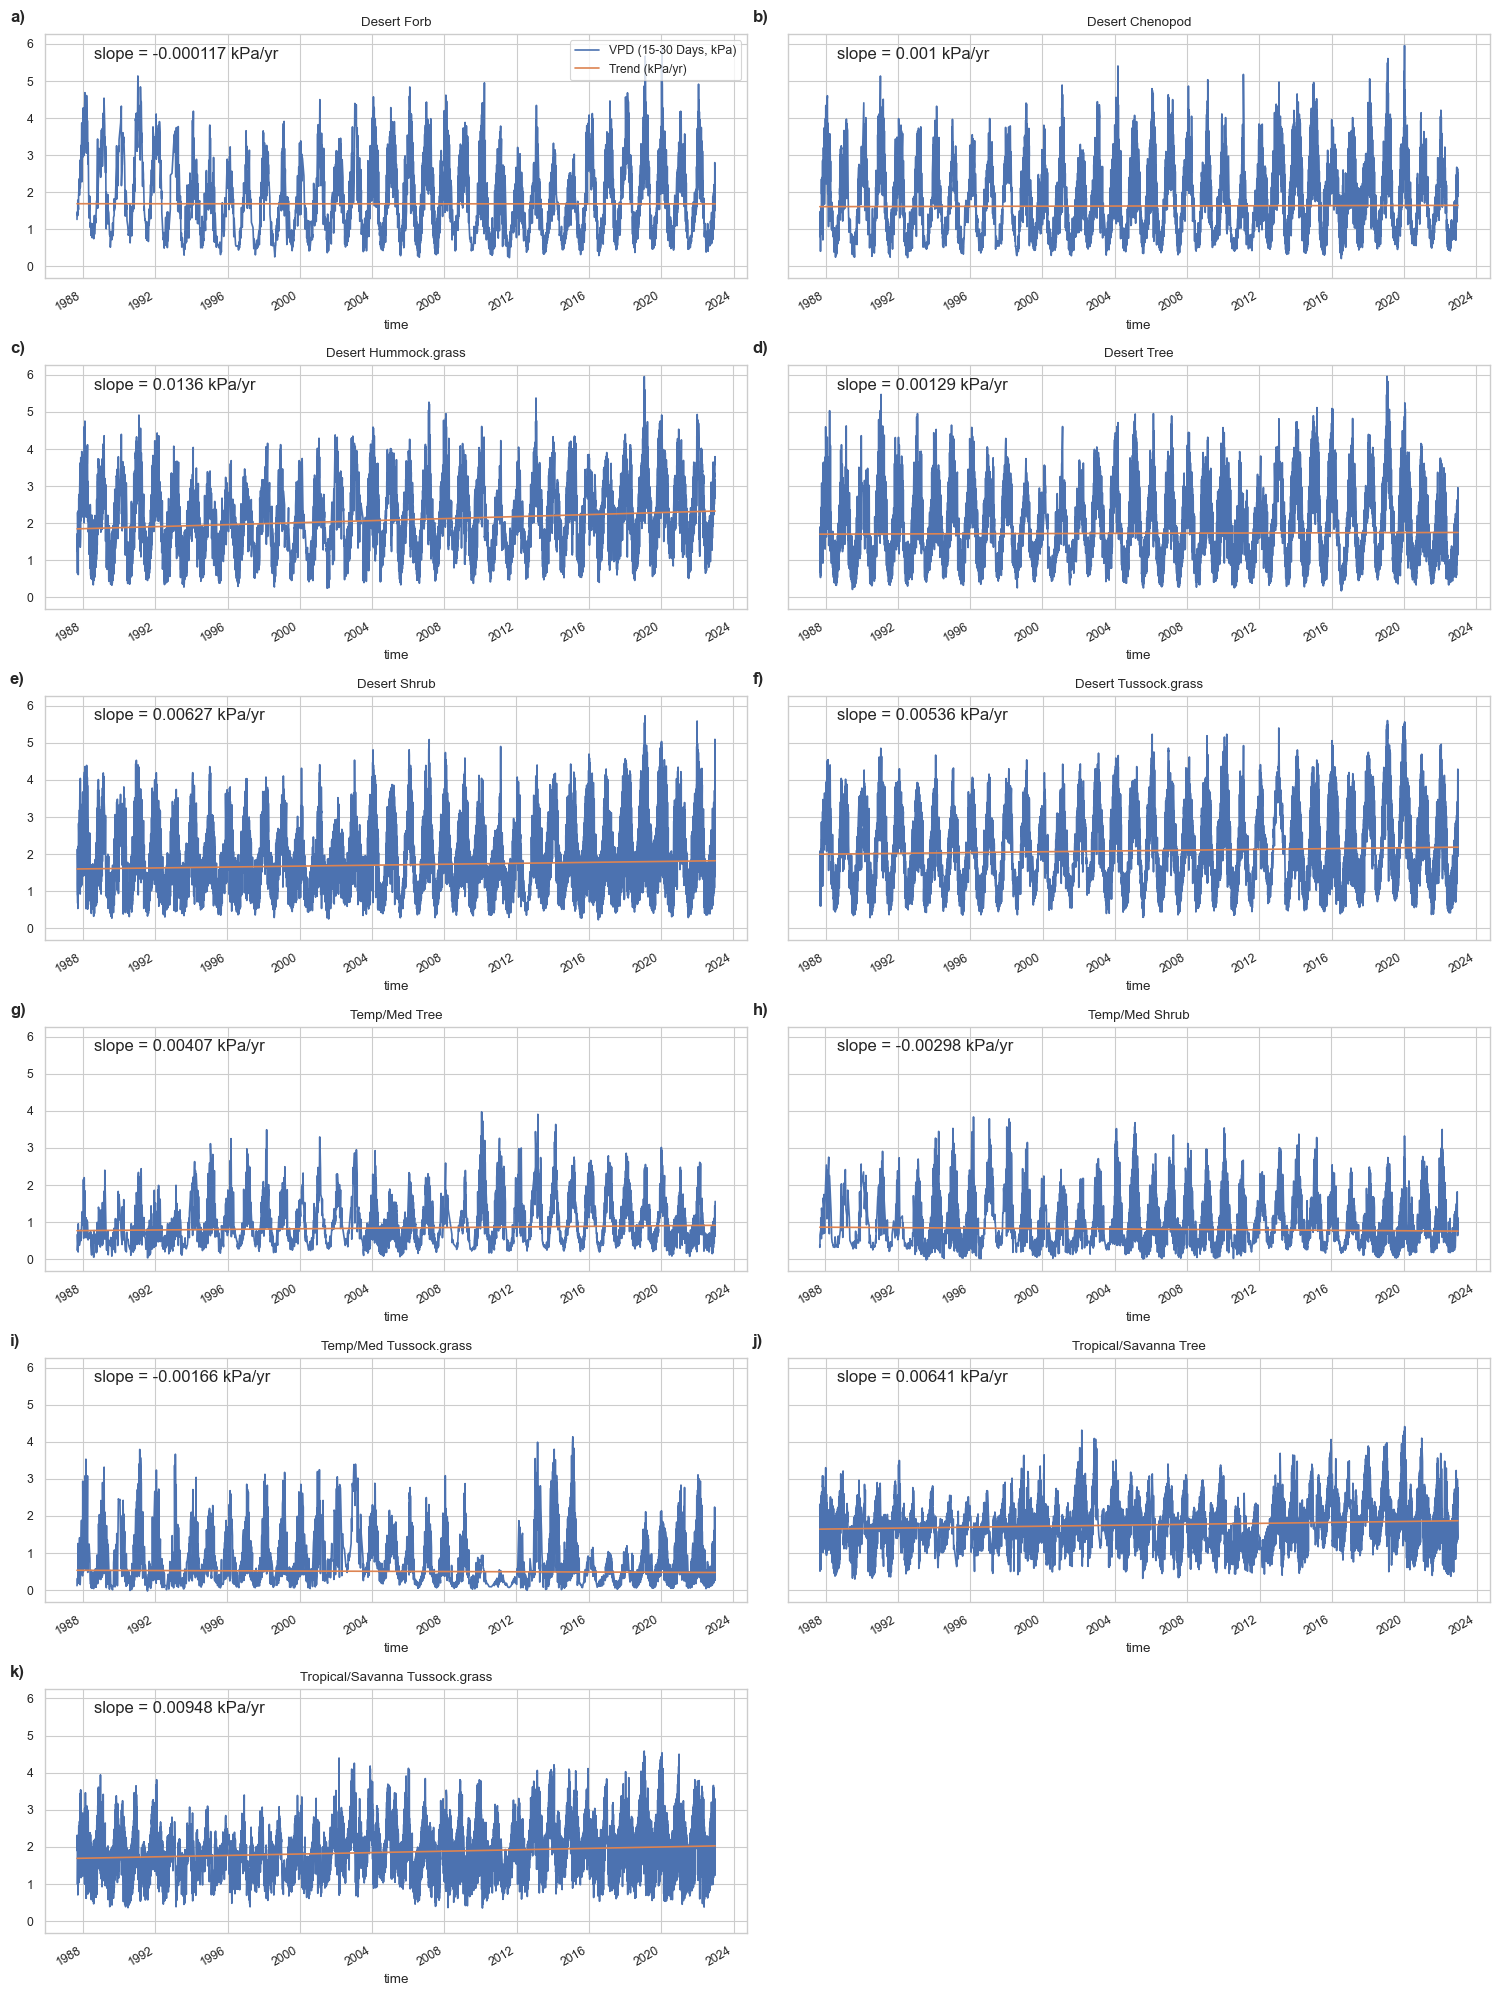

In [12]:
fig, axes = plt.subplots(6, 2, figsize = (15,20), sharey = True)

labels = ['a)', 'b)', 'c)',
          'd)', 'e)', 'f)',
          'g)', 'h)', 'i)',
          'j)', 'k)', 'k)']


for i, ax in enumerate(axes.flat):
    
    if i > 10:
        ax.axis('off') 
        break
    
    chosen_veg_type = ordered_veg_list[i]
    timeseries = pd.read_csv(f'{results_dir}/{chosen_veg_type}/Training/{chosen_veg_type}_Test_set.csv', parse_dates = ['time']).sort_values('time').set_index('time')
    timeseries['VPD_30'] = timeseries['VPD_30']/16
    timeseries['days'] = timeseries.index.map(pd.Timestamp.toordinal)
    
    res = stats.theilslopes(x = timeseries['days'], y = timeseries['VPD_30'],  alpha=0.95, method='separate')
    slope, intercept = res[0], res[1]
    timeseries['VPD_30_TREND'] = slope*timeseries['days'] + intercept
    print(slope)
    
    VPD_per_year = sigfig.round(slope *365, 3)
    ax.text(0.07, 0.95, f'slope = {VPD_per_year} kPa/yr', transform=ax.transAxes, 
            fontsize=12, va='top')
    
    
    timeseries.plot(y = ['VPD_30','VPD_30_TREND'], ax = ax)
    ax.title.set_text(ordered_veg_title[i])
    
    ax.text(-0.05, 1.1, labels[i], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top')
    
    if i == 0:
        handles = ax.get_legend_handles_labels()[0]
        new_labels = ['VPD (15-30 Days, kPa)', 'Trend (kPa/yr)']
        ax.legend(handles, new_labels, loc='upper right')
    else:
        ax.get_legend().remove()
        
    
fig.tight_layout()

In [13]:
fig.savefig(f'{plots_dir}/VPD_30_Trend_Plots.png', bbox_inches="tight")

In [ ]:
timeseries